# Data Science - Laboratorio 3
## Modelos Long-Short Term Memory (LSTM)
- - -
### Integrantes:
- Diego Alberto Leiva 21752
- José Pablo Orellana 21970
- - -

### Librerias

In [1]:
# Manejo de archivos
import os 

# Manipulación de datos
import pandas as pd
import numpy as np
from datetime import datetime

# Visualización
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Estadística y series temporales ARIMA
import statsmodels.tsa as tsa
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

# Métricas
from sklearn.metrics import mean_squared_error, accuracy_score

# advertencias
import warnings
warnings.filterwarnings('ignore')

### Carga de Datasets

In [2]:
# Ruta de la carpeta con los archivos
folder_path = 'data'

# Obtener los nombres de los archivos
file_names = [file for file in os.listdir(folder_path) if file.endswith('.csv') and not file.startswith('~')]

# Diccionario para almacenar los dataframes
data_frames = {}

# Iterar sobre los nombres de los archivos
for file in file_names:
    # Construir la ruta del archivo
    file_path = os.path.join(folder_path, file)
    file_name = file.split('.')[0]
    
    # Leer el archivo csv y almacenarlo en un dataframe
    df = pd.read_csv(file_path, sep=';', encoding='utf-8')
    
    # Guardar el dataframe en el diccionario con el nombre del archivo como clave
    data_frames[file_name] = df

# Mostrar los nombres de los archivos
print(f"Se cargaron un total de {len(data_frames)} archivos\n")
print('Archivos cargados:')
for key in data_frames.keys():
    print(f"\t- {key}")

Se cargaron un total de 3 archivos

Archivos cargados:
	- consumos_combustibles
	- importaciones_combustibles
	- precios_combustibles


In [3]:
# cargar cada dataset como su propio dataframe
consumos = data_frames['consumos_combustibles']
importaciones = data_frames['importaciones_combustibles']
precios = data_frames['precios_combustibles']

## Preprocesamiento

### Seleccion de Variables

Solo se tomarán en cuenta los datos de importación, consumo y precios de los siguientes tipos de combustibles:
- `Gasolina Súper`
- `Gasolina Regular`
- `Diesel` -> combinacion de Diesel alto azufre y bajo azufre
- `Gas Propano`

In [4]:
# Seleccionar las columnas de interés para consumos e importaciones
cols = ['Fecha','Gasolina regular', 'Gasolina superior', 'Diesel alto azufre', 'Diesel bajo azufre', 'Gas licuado de petróleo']

# Filtrar columnas en 'consumo_combustibles'
consumos = consumos[cols].copy()

# Filtrar columnas en 'importacion_combustibles'
importaciones = importaciones[cols].copy()

# Filtrar columnas en 'precios_combustibles'
precios_cols = ['FECHA','Superior GTQ/GALON', 'Regular GTQ/GALON', 'Diesel GTQ/GALON', 'Glp Cilindro 25Lbs GTQ/LB']
precios = precios[precios_cols].copy()

### Verificacion y manejo de Nulos

En el laboratorio anterior se encontro que Ceras y tipo cambio eran las variables con nulos. Dado que ahora se seleccionaron las variables de interes antes, es probable que ya no existan nulos.

In [5]:
# Comprobar si hay valores nulos
print("Valores nulos en el dataset de consumo de combustibles:", consumos.isnull().sum().sum())
print("Valores nulos en el dataset de importación de combustibles:", importaciones.isnull().sum().sum())
print("Valores nulos en el dataset de precios de combustibles:", precios.isnull().sum().sum())

Valores nulos en el dataset de consumo de combustibles: 0
Valores nulos en el dataset de importación de combustibles: 0
Valores nulos en el dataset de precios de combustibles: 0


### Manejo de Fechas

Anterormente se encontro que los 3 datasets contienen una unica variable culitativa la cual es `Fecha`. Esta se encuentra como string por lo que se debe de transformar a datetime

In [6]:
# Diccionario de meses en español a inglés
month_mapping = {
    'ene': 'Jan',
    'feb': 'Feb',
    'mar': 'Mar',
    'abr': 'Apr',
    'may': 'May',
    'jun': 'Jun',
    'jul': 'Jul',
    'ago': 'Aug',
    'sep': 'Sep',
    'oct': 'Oct',
    'nov': 'Nov',
    'dic': 'Dec'
}

# Función para reemplazar los nombres de los meses
def replace_months(date_str):
    for esp, eng in month_mapping.items():
        date_str = date_str.replace(esp, eng)
    return date_str

# Por fines practicos, se renombra la columna  'FECHA' a 'Fecha' en el dataset de precios de combustibles
precios.rename(columns={'FECHA': 'Fecha'}, inplace=True)

# Aplicar la función a las columnas de fecha de los dataframes
consumos['Fecha'] = consumos['Fecha'].apply(replace_months)
importaciones['Fecha'] = importaciones['Fecha'].apply(replace_months)
precios['Fecha'] = precios['Fecha'].apply(replace_months)

# Convertir las columnas de fecha a datetime
consumos['Fecha'] = pd.to_datetime(consumos['Fecha'], format='%b/%Y')
importaciones['Fecha'] = pd.to_datetime(importaciones['Fecha'], format='%b/%Y')
precios['Fecha'] = pd.to_datetime(precios['Fecha'], format='%d/%b/%Y')

# Establecer la columna 'Fecha' como índice en los tres dataframes
consumos.set_index('Fecha', inplace=True)
importaciones.set_index('Fecha', inplace=True)
precios.set_index('Fecha', inplace=True)

# Converir los indices a datetime
consumos.index = pd.to_datetime(consumos.index)
importaciones.index = pd.to_datetime(importaciones.index)
precios.index = pd.to_datetime(precios.index)

# Ordenar los índices
consumos.sort_index(inplace=True)
importaciones.sort_index(inplace=True)
precios.sort_index(inplace=True)

# Inferir la frecuencia de los índices
pd.infer_freq(consumos.index)
pd.infer_freq(importaciones.index)
pd.infer_freq(precios.index)


'D'

### Manejo de variables Diesel

Es necesario combinar ambas variables de diesel en una unica variable donde las fechas de antes del 2018 se tomaran para el diesel alto en azufre, posterior a 2018 se tomaran las de diesel alto en azufre.

In [7]:
def combine_diesel(df, high_sulfur_col, low_sulfur_col, combined_col):
    """
    Función que combina las columnas de Diesel de alto y bajo azufre en una sola columna.
    Toma los valores de Diesel de alto azufre hasta 2017 y los de Diesel de bajo azufre a partir de 2018.

    Args:
        df (pandas.DataFrame): El dataframe de entrada.
        high_sulfur_col (str): El nombre de la columna de Diesel de alto azufre.
        low_sulfur_col (str): El nombre de la columna de Diesel de bajo azufre.
        combined_col (str): El nombre de la nueva columna combinada.
    
    Returns:
        data (pandas.DataFrame): El dataframe de entrada con la nueva columna combinada.
    """
    # Crear una copia del dataframe
    data = df.copy()

    # Crear una nueva columna con los valores de Diesel de alto azufre
    data.loc[data.index < '2018-01-01', combined_col] = data[high_sulfur_col]
    data.loc[data.index >= '2018-01-01', combined_col] = data[low_sulfur_col]

    # Eliminar las columnas originales
    data.drop(columns=[high_sulfur_col, low_sulfur_col], inplace=True)

    return data

In [8]:
# Combina las columnas de Diesel de alto y bajo azufre en una sola columna
consumos = combine_diesel(consumos, 'Diesel alto azufre', 'Diesel bajo azufre', 'Diesel')
importaciones = combine_diesel(importaciones, 'Diesel alto azufre', 'Diesel bajo azufre', 'Diesel')

### Renombrar Variables

Por fines practicos se renombraran las variables

In [9]:
precios.rename(columns={
    'Superior GTQ/GALON': 'Gasolina Superior',
    'Regular GTQ/GALON': 'Gasolina Regular',
    'Diesel GTQ/GALON': 'Diesel',
    'Glp Cilindro 25Lbs GTQ/LB': 'Gas Propano'
}, inplace=True)

# Renombrar columnas en 'consumo_combustibles'
consumos.rename(columns={
    'Gasolina regular': 'Gasolina Regular',
    'Gasolina superior': 'Gasolina Superior',
    'Gas licuado de petróleo': 'Gas Propano'
}, inplace=True)

# Renombrar columnas en 'importacion_combustibles'
importaciones.rename(columns={
    'Gasolina regular': 'Gasolina Regular',
    'Gasolina superior': 'Gasolina Superior',
    'Gas licuado de petróleo': 'Gas Propano'
}, inplace=True)

In [10]:
# Convertir los datasets a dataframes individuales

# Consumos
super_consumos = consumos['Gasolina Superior']
regular_consumos = consumos['Gasolina Regular']
diesel_consumos = consumos['Diesel']
propano_consumos = consumos['Gas Propano']

# Importaciones
super_importaciones = importaciones['Gasolina Superior']
regular_importaciones = importaciones['Gasolina Regular']
diesel_importaciones = importaciones['Diesel']
propano_importaciones = importaciones['Gas Propano']

# Precios
super_precios = precios['Gasolina Superior']
regular_precios = precios['Gasolina Regular']
diesel_precios = precios['Diesel']
propano_precios = precios['Gas Propano']

## Modelos ARIMA

In [11]:
def get_model_params(series, seasonal_period=None, variable_name=None):
    # Log transformation if variance is increasing with level
    log_series = np.log(series + 1)  # Add 1 to avoid log(0) issues
    
    # Fit auto_arima model
    model = pm.auto_arima(log_series,
                          seasonal=True, 
                          m=seasonal_period, 
                          trace=False,
                          error_action='ignore', 
                          suppress_warnings=True, 
                          stepwise=True)
    # Extract model parameters
    model_params = {
        'p': model.order[0],
        'd': model.order[1],
        'q': model.order[2],
        'P': model.seasonal_order[0],
        'D': model.seasonal_order[1],
        'Q': model.seasonal_order[2],
        'S': model.seasonal_order[3],
        'aic': model.aic()
    }
    
    # Apply differencing based on d parameter
    differenced_series = log_series.copy()
    for _ in range(int(model_params['d'])):
        differenced_series = differenced_series.diff().dropna()

    print("-"*10,f"Model for {variable_name}", "-"*10)
    print(f"Model parameters: {model_params}")
    
    
    return model_params, differenced_series

In [12]:
def inverse_log_transformation(log_series):
    return np.exp(log_series) - 1

In [13]:
def evaluate_sarimax(series, test_size, model_params, variable):
    # Extract model parameters
    order = (model_params['p'], model_params['d'], model_params['q'])
    seasonal_order = (model_params['P'], model_params['D'], model_params['Q'], model_params['S'])
    
    # Split data into training and test sets
    train = series[:-test_size]
    test = series[-test_size:]
    
    # Ajustar el modelo SARIMAX con el conjunto de entrenamiento
    model = SARIMAX(train, order=order, 
                    seasonal_order=seasonal_order, 
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    results = model.fit()
    
    # Hacer predicciones
    start = len(series) - test_size
    end = len(series) - 1
    
    prediction = results.predict(start=start, end=end, typ='levels')

    # Convert predictions back to original scale if log-transformed
    prediction = inverse_log_transformation(prediction)
    test_df = test.to_frame()  # Convert series to dataframe for accuracy calculation
    test_df['Predictions'] = prediction
    
    # Calcular RMSE
    rmse = np.sqrt(mean_squared_error(test_df[variable], test_df['Predictions']))
    
    # Calculate accuracy (if applicable)
    # Accuracy can be tricky for continuous data; you might use a threshold for binary classification or just evaluate other metrics
    accuracy = np.mean(np.abs(test_df[variable] - test_df['Predictions']) < 0.1)  # Example threshold
    
    print('-'*10,f'Metricas {variable}','-'*10)
    print(f'RMSE: {rmse}')
    print(f'Accuracy: {accuracy * 100:.2f}%')

    return rmse, accuracy, train, test_df

In [14]:
def plot_arima_predictions(train, test_df, variable):
        # Ajustar el gráfico
        plt.figure(figsize=(15, 5))
        
        # Recortar el conjunto de datos de entrenamiento para mostrar solo el intervalo de prueba
        train_plot = train.copy()
        train_plot = train_plot[train_plot.index >= test_df.index[0]]
        
        plt.plot(train_plot, label='Observed Train Data', color='blue')
        plt.plot(test_df[variable], label='Observed Test Data', color='green')
        plt.plot(test_df['Predictions'], label='Predictions', linestyle='--', color='red')
        
        plt.legend()
        plt.title('Observed Train and Test Data with Predictions')
        plt.show()

In [15]:
print("Modelos ARIMA para los datos de Consumo de Combustibles")
super_consumos_params, super_consumos_diff = get_model_params(super_consumos, seasonal_period=12, variable_name='Superior')
regular_consumos_params, regular_consumos_diff = get_model_params(regular_consumos, seasonal_period=12, variable_name='Regular')
diesel_consumos_params, diesel_consumos_diff = get_model_params(diesel_consumos, seasonal_period=12, variable_name='Diesel')
propano_consumos_params, propano_consumos_diff = get_model_params(propano_consumos, seasonal_period=12, variable_name='Propano')

print("Modelos ARIMA para los datos de Importaciones de Combustibles")
super_importaciones_params, super_importaciones_diff = get_model_params(super_importaciones, seasonal_period=12, variable_name='Superior')
regular_importaciones_params, regular_importaciones_diff = get_model_params(regular_importaciones, seasonal_period=12, variable_name='Regular')
diesel_importaciones_params, diesel_importaciones_diff = get_model_params(diesel_importaciones, seasonal_period=12, variable_name='Diesel')
propano_importaciones_params, propano_importaciones_diff = get_model_params(propano_importaciones, seasonal_period=12, variable_name='Propano')

print("Modelos ARIMA para los datos de Precios de Combustibles")
super_precios_params, super_precios_diff = get_model_params(super_precios, seasonal_period=365, variable_name='Superior')
regular_precios_params, regular_precios_diff = get_model_params(regular_precios, seasonal_period=365, variable_name='Regular')
diesel_precios_params, diesel_precios_diff = get_model_params(diesel_precios, seasonal_period=365, variable_name='Diesel')
propano_precios_params, propano_precios_diff = get_model_params(propano_precios, seasonal_period=365, variable_name='Propano')

Modelos ARIMA para los datos de Consumo de Combustibles
---------- Model for Superior ----------
Model parameters: {'p': 3, 'd': 1, 'q': 2, 'P': 1, 'D': 0, 'Q': 1, 'S': 12, 'aic': -798.8398342318333}
---------- Model for Regular ----------
Model parameters: {'p': 2, 'd': 1, 'q': 3, 'P': 1, 'D': 0, 'Q': 1, 'S': 12, 'aic': -725.8115567507296}
---------- Model for Diesel ----------
Model parameters: {'p': 1, 'd': 1, 'q': 1, 'P': 1, 'D': 0, 'Q': 2, 'S': 12, 'aic': -729.26951290592}
---------- Model for Propano ----------
Model parameters: {'p': 0, 'd': 1, 'q': 1, 'P': 1, 'D': 0, 'Q': 1, 'S': 12, 'aic': -914.7306761975609}
Modelos ARIMA para los datos de Importaciones de Combustibles
---------- Model for Superior ----------
Model parameters: {'p': 2, 'd': 1, 'q': 1, 'P': 1, 'D': 0, 'Q': 0, 'S': 12, 'aic': -14.023678228141467}
---------- Model for Regular ----------
Model parameters: {'p': 1, 'd': 1, 'q': 2, 'P': 0, 'D': 0, 'Q': 0, 'S': 12, 'aic': 42.16513292794818}
---------- Model for Dies

KeyboardInterrupt: 

In [16]:
print('CONSUMOS')
super_consumos_rmse, super_consumos_acc, super_consumos_train, super_consumos_test = evaluate_sarimax(super_consumos_diff, 36, super_consumos_params, 'Gasolina Superior')
regular_consumos_rmse, regular_consumos_acc, regular_consumos_train, regular_consumos_test = evaluate_sarimax(regular_consumos_diff, 36, regular_consumos_params, 'Gasolina Regular')
diesel_consumos_rmse, diesel_consumos_acc, diesel_consumos_train, diesel_consumos_test = evaluate_sarimax(diesel_consumos_diff, 36, diesel_consumos_params, 'Diesel')
propano_consumos_rmse, propano_consumos_acc, propano_consumos_train, propano_consumos_test = evaluate_sarimax(propano_consumos_diff, 36, propano_consumos_params, 'Gas Propano')

print('IMPORTACIONES')
super_importaciones_rmse, super_importaciones_acc, super_importaciones_train, super_importaciones_test = evaluate_sarimax(super_importaciones_diff, 36, super_importaciones_params, 'Gasolina Superior')
regular_importaciones_rmse, regular_importaciones_acc, regular_importaciones_train, regular_importaciones_test = evaluate_sarimax(regular_importaciones_diff, 36, regular_importaciones_params, 'Gasolina Regular')
diesel_importaciones_rmse, diesel_importaciones_acc, diesel_importaciones_train, diesel_importaciones_test = evaluate_sarimax(diesel_importaciones_diff, 36, diesel_importaciones_params, 'Diesel')
propano_importaciones_rmse, propano_importaciones_acc, propano_importaciones_train, propano_importaciones_test = evaluate_sarimax(propano_importaciones_diff, 36, propano_importaciones_params, 'Gas Propano')

# print('PRECIOS')
# super_precios_rmse, super_precios_acc, super_precios_train, super_precios_test = evaluate_sarimax(super_precios_diff, 365, super_precios_params, 'Gasolina Superior')
# regular_precios_rmse, regular_precios_acc, regular_precios_train, regular_precios_test = evaluate_sarimax(regular_precios_diff, 365, regular_precios_params, 'Gasolina Regular')
# diesel_precios_rmse, diesel_precios_acc, diesel_precios_train, diesel_precios_test = evaluate_sarimax(diesel_precios_diff, 365, diesel_precios_params, 'Diesel')
# propano_precios_rmse, propano_precios_acc, propano_precios_train, propano_precios_test = evaluate_sarimax(propano_precios_diff, 365, propano_precios_params, 'Gas Propano')

CONSUMOS
---------- Metricas Gasolina Superior ----------
RMSE: 0.07169028729607073
Accuracy: 86.11%
---------- Metricas Gasolina Regular ----------
RMSE: 0.0639980420867461
Accuracy: 83.33%
---------- Metricas Diesel ----------
RMSE: 0.08823780469741083
Accuracy: 77.78%
---------- Metricas Gas Propano ----------
RMSE: 0.05929864274821683
Accuracy: 88.89%
IMPORTACIONES
---------- Metricas Gasolina Superior ----------
RMSE: 0.20745569728649815
Accuracy: 44.44%
---------- Metricas Gasolina Regular ----------
RMSE: 0.19243260256076064
Accuracy: 33.33%
---------- Metricas Diesel ----------
RMSE: 0.20478647972710706
Accuracy: 33.33%
---------- Metricas Gas Propano ----------
RMSE: 0.48321365081670054
Accuracy: 38.89%


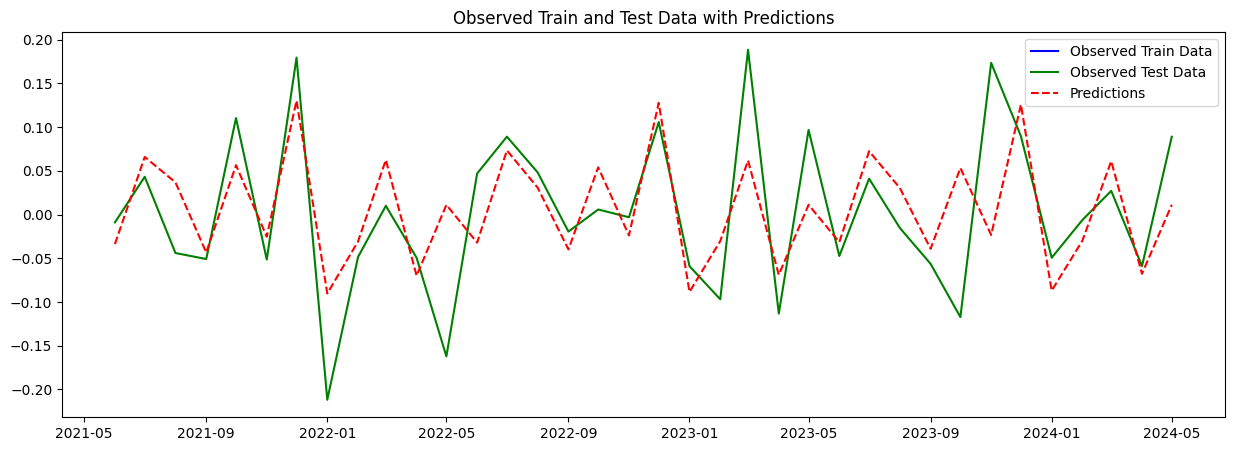

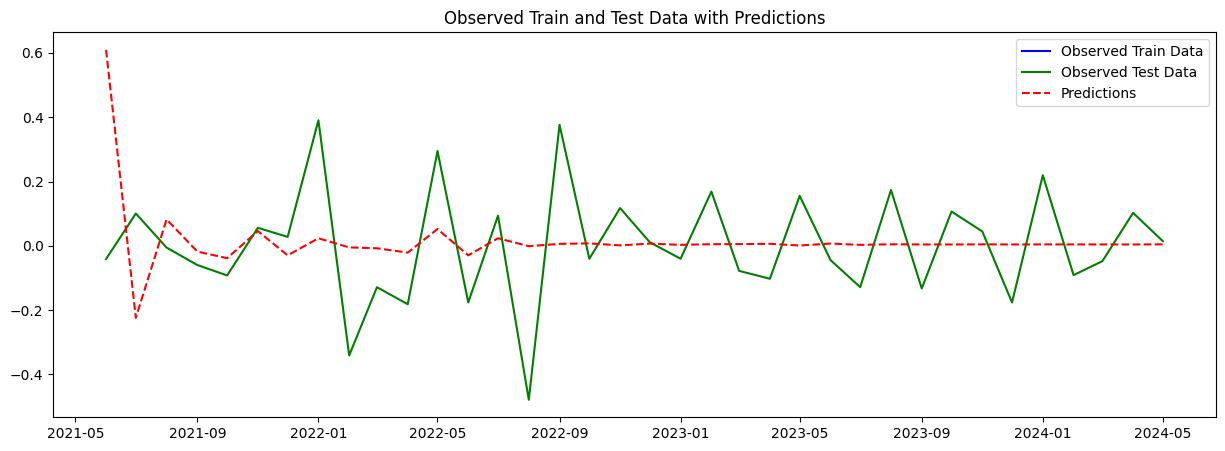

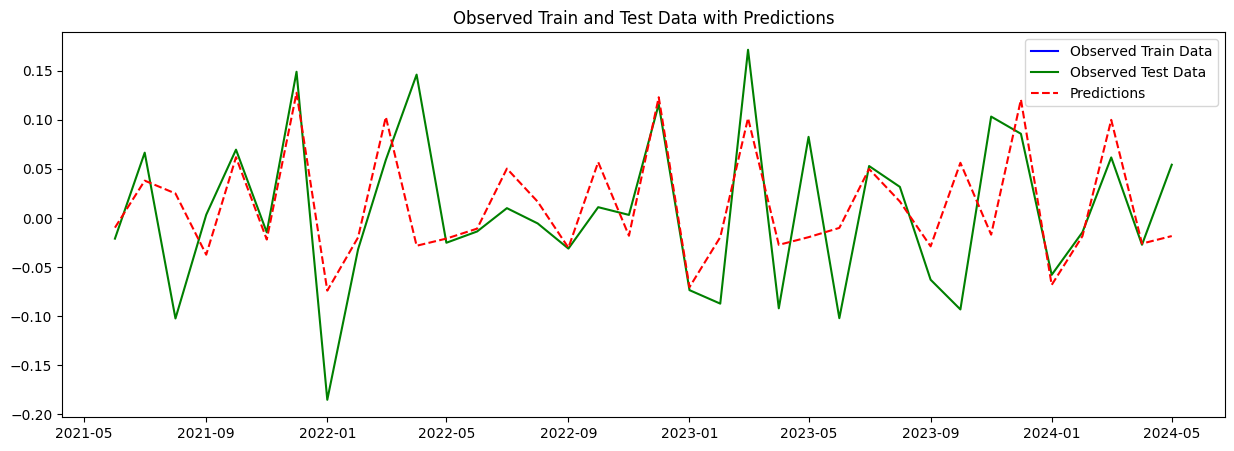

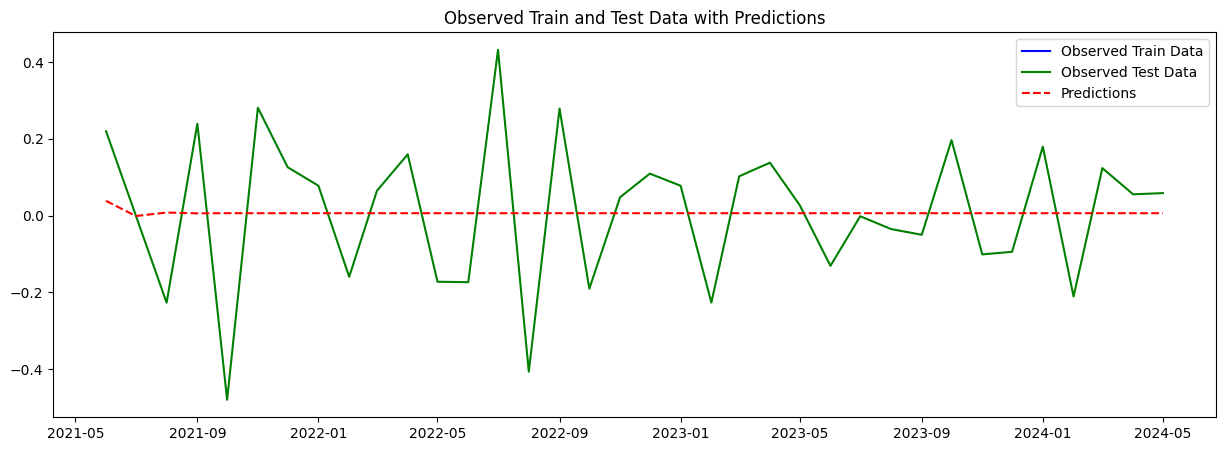

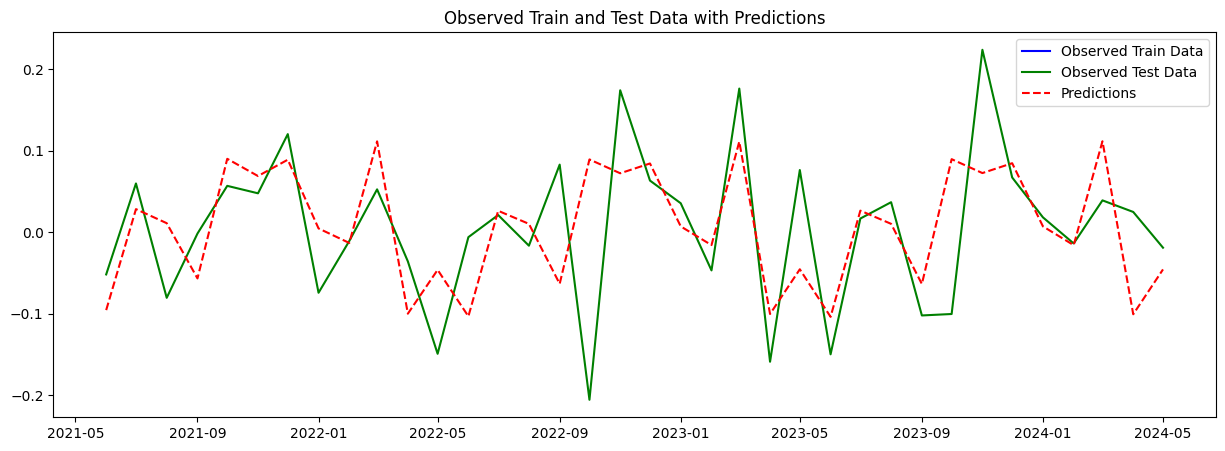

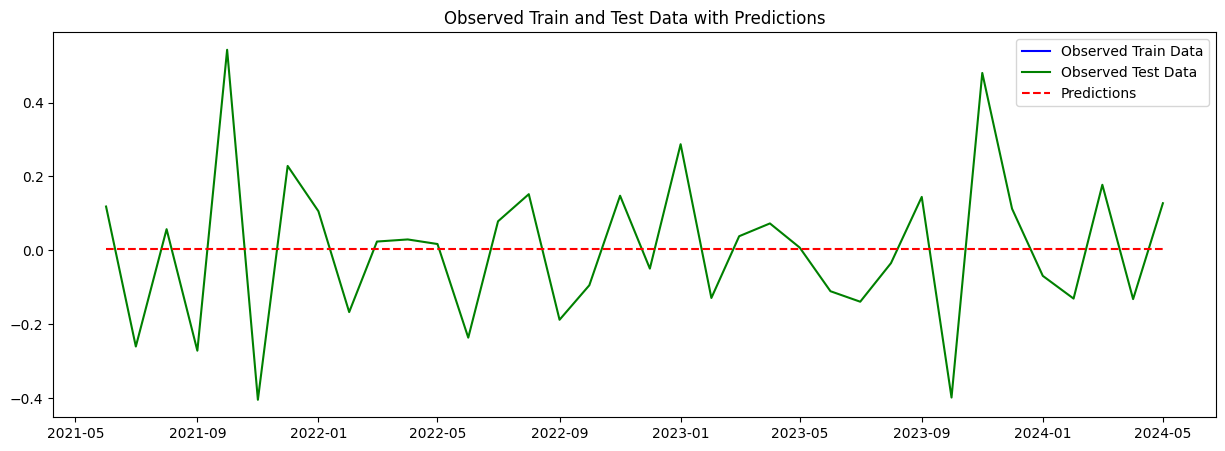

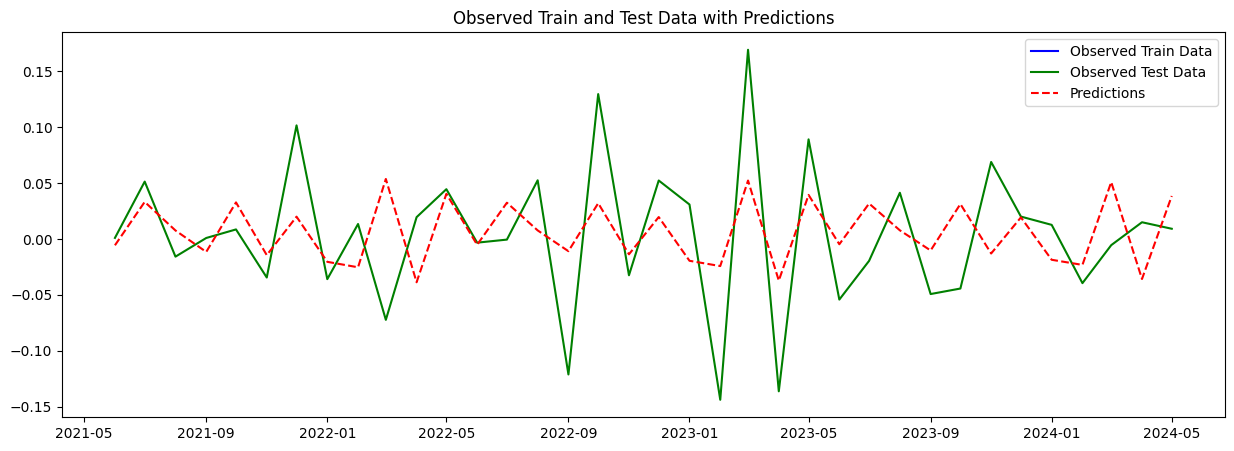

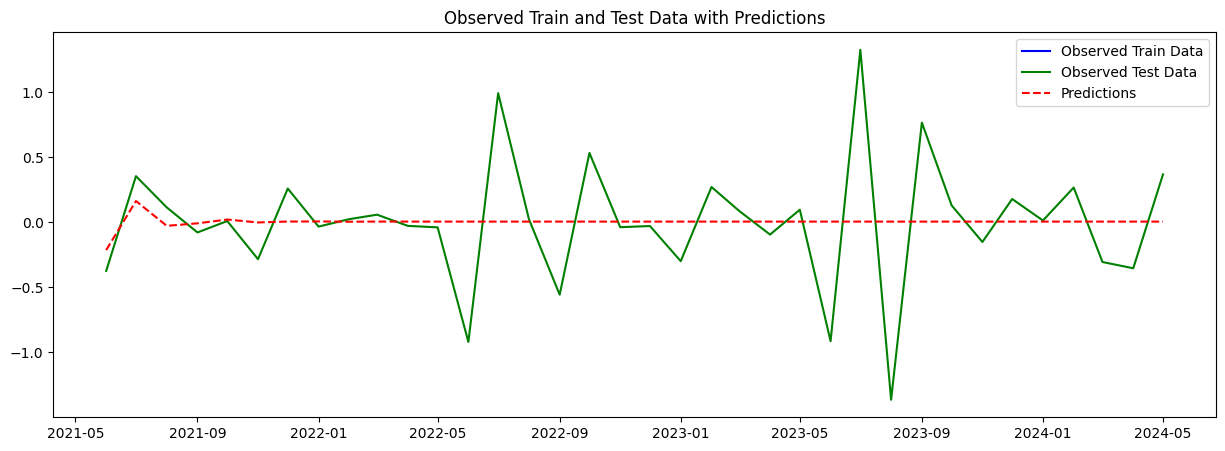

In [17]:
plot_arima_predictions(super_consumos_train, super_consumos_test, 'Gasolina Superior')
plot_arima_predictions(super_importaciones_train, super_importaciones_test, 'Gasolina Superior')
# plot_arima_predictions(super_precios_train, super_precios_test, 'Gasolina Superior')

plot_arima_predictions(regular_consumos_train, regular_consumos_test, 'Gasolina Regular')
plot_arima_predictions(regular_importaciones_train, regular_importaciones_test, 'Gasolina Regular')
# plot_arima_predictions(regular_precios_train, regular_precios_test, 'Gasolina Regular')

plot_arima_predictions(diesel_consumos_train, diesel_consumos_test, 'Diesel')
plot_arima_predictions(diesel_importaciones_train, diesel_importaciones_test, 'Diesel')
# plot_arima_predictions(diesel_precios_train, diesel_precios_test, 'Diesel')

plot_arima_predictions(propano_consumos_train, propano_consumos_test, 'Gas Propano')
plot_arima_predictions(propano_importaciones_train, propano_importaciones_test, 'Gas Propano')
# plot_arima_predictions(propano_precios_train, propano_precios_test, 'Gas Propano')